In [22]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sci
import qutip as qt
from qutip import (Qobj, about, basis, coherent, coherent_dm, create, destroy,
                   expect, fock, fock_dm, mesolve, qeye, sigmax, sigmay,
                   sigmaz, tensor, thermal_dm)
import lattpy as lp
from scipy.optimize import curve_fit
from scipy.linalg import expm
from scipy.linalg import eigvals

from IPython.display import clear_output
from matplotlib.animation import FuncAnimation
from IPython import display
import os
import matplotlib as mpl

In [23]:
"""system with N=11 atoms, to get the subradiant state of the system for a later initialization of the other system"""

N=11
gamma0 = 1
lambda0= 2*np.pi 
distance=lambda0/8 
k0=1 
d_value=1 

atoms = np.zeros((N, 3))
for i in range(N):
    atoms[i, 2] = i * distance*k0
r = [atoms[i] for i in range(N)]
r_T = [i.reshape(-1, 1) for i in r]


d=np.array([0,d_value,0])
d_abs=np.linalg.norm(d)
d = d.reshape(-1, 1)
d_T=d.reshape(1, -1)


def G0(rij,k0): 
    r0=np.linalg.norm(rij)
    rij_T = rij.reshape(-1, 1)
    return ((3*np.pi*k0*np.exp(1j*k0*r0))/(4*np.pi*(k0*r0)**3))*((k0**2*r0**2+1j*k0*r0-1)*np.identity(3)+((-k0**2*r0**2-3j*k0*r0+3)*(np.dot(rij,rij_T)/r0**2)))

def H_eff1(r,d,N):
    Matrix = np.zeros((N,N), dtype=complex)
    k0=1
    for i in range(N):
        for j in range(N):
            if i == j:
                Matrix[i, j] += -1j*gamma0/2
            else:
                rij = r[i] - r[j]
                Matrix[i, j] += -np.dot(d_T, np.dot(G0(rij,k0), d))
    return  Matrix
Hamiltonian1 = H_eff1(r,d,N)

eigenvalues_11, eigenvectors_11 = np.linalg.eig(Hamiltonian1)
index = np.argmax(np.imag(eigenvalues_11))
psi_11_subradiant = eigenvectors_11[:, index] 
psi_11_subradiant = psi_11_subradiant / np.linalg.norm(psi_11_subradiant)



In [24]:
"""system with N=3 atoms, to get the subradiant state of the system for a later initialization of the other system"""

N=3
gamma0 = 1
lambda0= 2*np.pi 
distance=lambda0/8 
k0=1 
d_value=1 

atoms = np.zeros((N, 3))
for i in range(N):
    atoms[i, 2] = i * distance*k0
r = [atoms[i] for i in range(N)]
r_T = [i.reshape(-1, 1) for i in r]


d=np.array([0,d_value,0])
d_abs=np.linalg.norm(d)
d = d.reshape(-1, 1)
d_T=d.reshape(1, -1)


def G0(rij,k0): 
    r0=np.linalg.norm(rij)
    rij_T = rij.reshape(-1, 1)
    return ((3*np.pi*k0*np.exp(1j*k0*r0))/(4*np.pi*(k0*r0)**3))*((k0**2*r0**2+1j*k0*r0-1)*np.identity(3)+((-k0**2*r0**2-3j*k0*r0+3)*(np.dot(rij,rij_T)/r0**2)))

def H_eff2(r,d,N):
    Matrix = np.zeros((N,N), dtype=complex)
    k0=1
    for i in range(N):
        for j in range(N):
            if i == j:
                Matrix[i, j] += -1j*gamma0/2
            else:
                rij = r[i] - r[j]
                Matrix[i, j] += -np.dot(d_T, np.dot(G0(rij,k0), d))
    return  Matrix
Hamiltonian2 = H_eff2(r,d,N)

eigenvalues_3, eigenvectors_3 = np.linalg.eig(Hamiltonian2)
index = np.argmax(np.imag(eigenvalues_3))
psi_03_subradiant = eigenvectors_3[:, index] 
psi_03_subradiant = psi_03_subradiant / np.linalg.norm(psi_03_subradiant)



In [25]:
"""excitation subradient state of the long chain--> movement of the samller chain towards and back"""
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'



N = 11
N2 = 3
gamma0 = 1
lambda0 = 2 * np.pi
k0 = 1
d_value = 1
dt = 0.1
T = 1500
distance = lambda0 / 8
middle_index = N // 2  

atoms1 = np.zeros((N, 3))
for i in range(N):
    atoms1[i, 2] = i * distance * k0  

atoms2 = np.zeros((N2, 3))
initial_distance = 4 * np.pi
for i in range(N2):
    atoms2[i, 2] = (middle_index - N2 // 2 + i) * distance * k0 
    atoms2[i, 1] = initial_distance 

d = np.array([d_value, 0, 0]).reshape(-1, 1)
d_T = d.T


def H_eff(r1, r2, d, N, N2):
    Matrix = np.zeros((N + N2, N + N2), dtype=np.complex128)
    for i in range(N + N2):
        for j in range(N + N2):
            if i == j:
                Matrix[i, j] += -1j * gamma0 / 2
            else:
                if i < N and j < N: 
                    rij = r1[i] - r1[j]
                elif i >= N and j >= N:  
                    rij = r2[i-N] - r2[j-N]
                elif i < N and j >= N:  
                    rij = r1[i] - r2[j-N]
                else:  
                    rij = r2[i-N] - r1[j]
                Matrix[i, j] += -d_T @ G0(rij, k0) @ d
    return Matrix

psi_0 = np.zeros(N + N2, dtype=np.complex128)
psi_0[0:11]=psi_11_subradiant


population_chain1 = []
population_chain2 = []
population_total = []

initial_distance = 4 * np.pi
target_distance = np.pi / 5
speed = (initial_distance - target_distance) / 50

time = np.arange(0, T, dt)

"""movement of the system for every time step"""
for t in time:
    if 0 <= t <= 50:
        for i in range(N2):
            atoms2[i, 1] -= dt * speed
    elif 50 < t <= 100:
        for i in range(N2):
            atoms2[i, 1] += dt * speed

    """evolution of the system for every time step""" 
    Hamiltonian = H_eff(atoms1, atoms2, d, N, N2)
    psi_t = expm(-1j * Hamiltonian * dt) @ psi_0
    psi_0 = psi_t

    population_chain1.append(np.sum(np.abs(psi_t[:N])**2))
    population_chain2.append(np.sum(np.abs(psi_t[N:N+N2])**2))
    population_total.append(np.sum(np.abs(psi_t)**2))

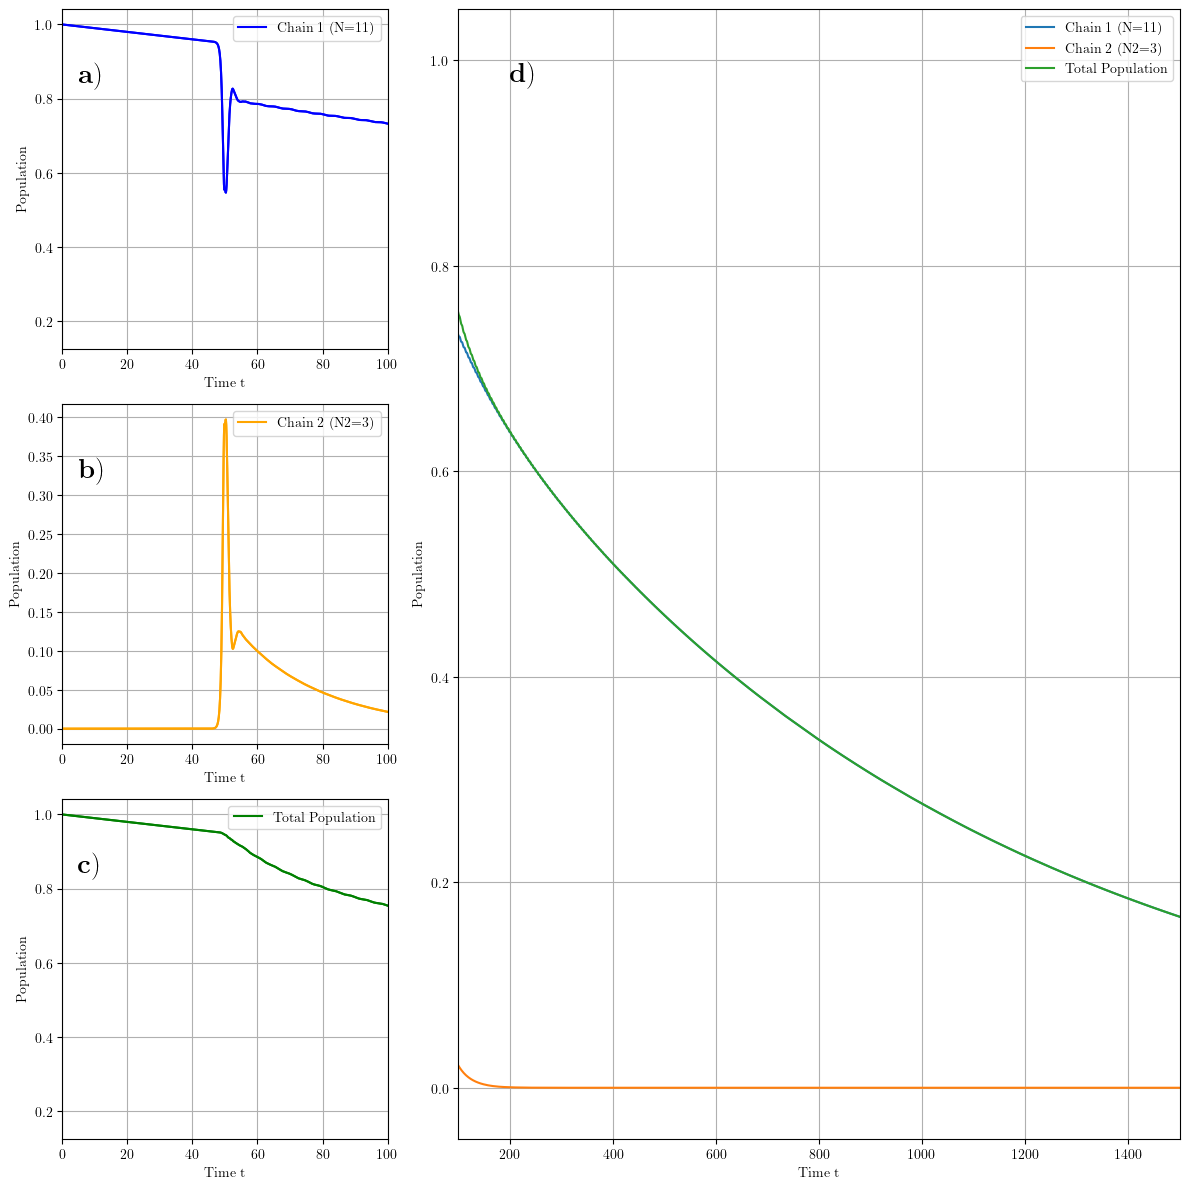

In [26]:
fig = plt.figure(figsize=(12, 12))

color_chain1 = 'blue'
color_chain2 = 'orange'
color_total = 'green'



ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
ax1.plot(time, population_chain1, color=color_chain1)
ax1.set_xlim(0,100)
ax1.text(5, 0.9, r'$\mathbf{a)}$', fontsize=20, fontweight='bold', verticalalignment='top')
ax1.grid(True)

ax2 = plt.subplot2grid((3, 3), (1, 0), colspan=1)
ax2.plot(time, population_chain2, color=color_chain2 )
ax2.text(5, 0.35, r'$\mathbf{b)}$', fontsize=20, fontweight='bold', verticalalignment='top')
ax2.set_xlim(0,100)
ax2.grid(True)

ax3 = plt.subplot2grid((3, 3), (2, 0), colspan=1)
ax3.plot(time, population_total, color=color_total)
ax3.text(5, 0.9, r'$\mathbf{c)}$', fontsize=20, fontweight='bold', verticalalignment='top')
ax3.set_xlim(0,100)
ax3.grid(True)

ax4 = plt.subplot2grid((3, 3), (0, 1), rowspan=3, colspan=2)
ax4.plot(time, population_chain1, label=' Chain 1 (N=11)')
ax4.plot(time, population_chain2, label=' Chain 2 (N2=3)')
ax4.plot(time, population_total, label='Total Population')
ax4.set_xlim(100, T)
ax4.text(200, 1, r'$\mathbf{d)}$', fontsize=20, fontweight='bold', verticalalignment='top')
ax4.grid(True)

ax1.plot(time, population_chain1, label=' Chain 1 (N=11)', color=color_chain1)
ax2.plot(time, population_chain2, label=r' Chain 2 (N2=3)', color=color_chain2)
ax3.plot(time, population_total, label='Total Population', color=color_total)

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel(r'Time t')
    ax.set_ylabel(r'Population')
    ax.legend()

plt.tight_layout()
plt.show()

In [27]:
"""system with N=3 atoms and N2=11 atoms, N=3 chain is in the most subradiant state initialized, long chain moves towards the small chain"""


plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'



N = 3
N2 = 11
gamma0 = 1
lambda0 = 2 * np.pi
k0 = 1
d_value = 1
dt = 0.1
T = 1500
distance = lambda0 / 8
middle_index = N // 2  


atoms1 = np.zeros((N, 3))
for i in range(N):
    atoms1[i, 2] = i * distance * k0  

atoms2 = np.zeros((N2, 3))
initial_distance = 4 * np.pi
for i in range(N2):
    atoms2[i, 2] = (middle_index - N2 // 2 + i) * distance * k0  
    atoms2[i, 1] = initial_distance 


def H_eff(r1, r2, d, N, N2):
    Matrix = np.zeros((N + N2, N + N2), dtype=np.complex128)
    for i in range(N + N2):
        for j in range(N + N2):
            if i == j:
                Matrix[i, j] += -1j * gamma0 / 2
            else:
                if i < N and j < N: 
                    rij = r1[i] - r1[j]
                elif i >= N and j >= N:  
                    rij = r2[i-N] - r2[j-N]
                elif i < N and j >= N:  
                    rij = r1[i] - r2[j-N]
                else:  
                    rij = r2[i-N] - r1[j]
                Matrix[i, j] += -d_T @ G0(rij, k0) @ d
    return Matrix



psi_0 = np.zeros(N + N2, dtype=np.complex128)
psi_0[:N] = psi_03_subradiant


population_chain1 = []
population_chain2 = []
population_total = []

initial_distance = 4 * np.pi
target_distance = np.pi / 5
speed2 = (initial_distance - target_distance) / 20
time = np.arange(0, T, dt)

for t in time:
    if 0 <= t <= 20:
        for i in range(N2):
            atoms2[i, 1] -= dt * speed2
    elif 20 < t <= 40:
        for i in range(N2):
            atoms2[i, 1] += dt * speed2

    Hamiltonian = H_eff(atoms1, atoms2, d, N, N2)
    psi_t = expm(-1j * Hamiltonian * dt) @ psi_0
    psi_0 = psi_t  

    population_chain1.append(np.sum(np.abs(psi_t[:N])**2))
    population_chain2.append(np.sum(np.abs(psi_t[N:N+N2])**2))
    population_total.append(np.sum(np.abs(psi_t)**2))

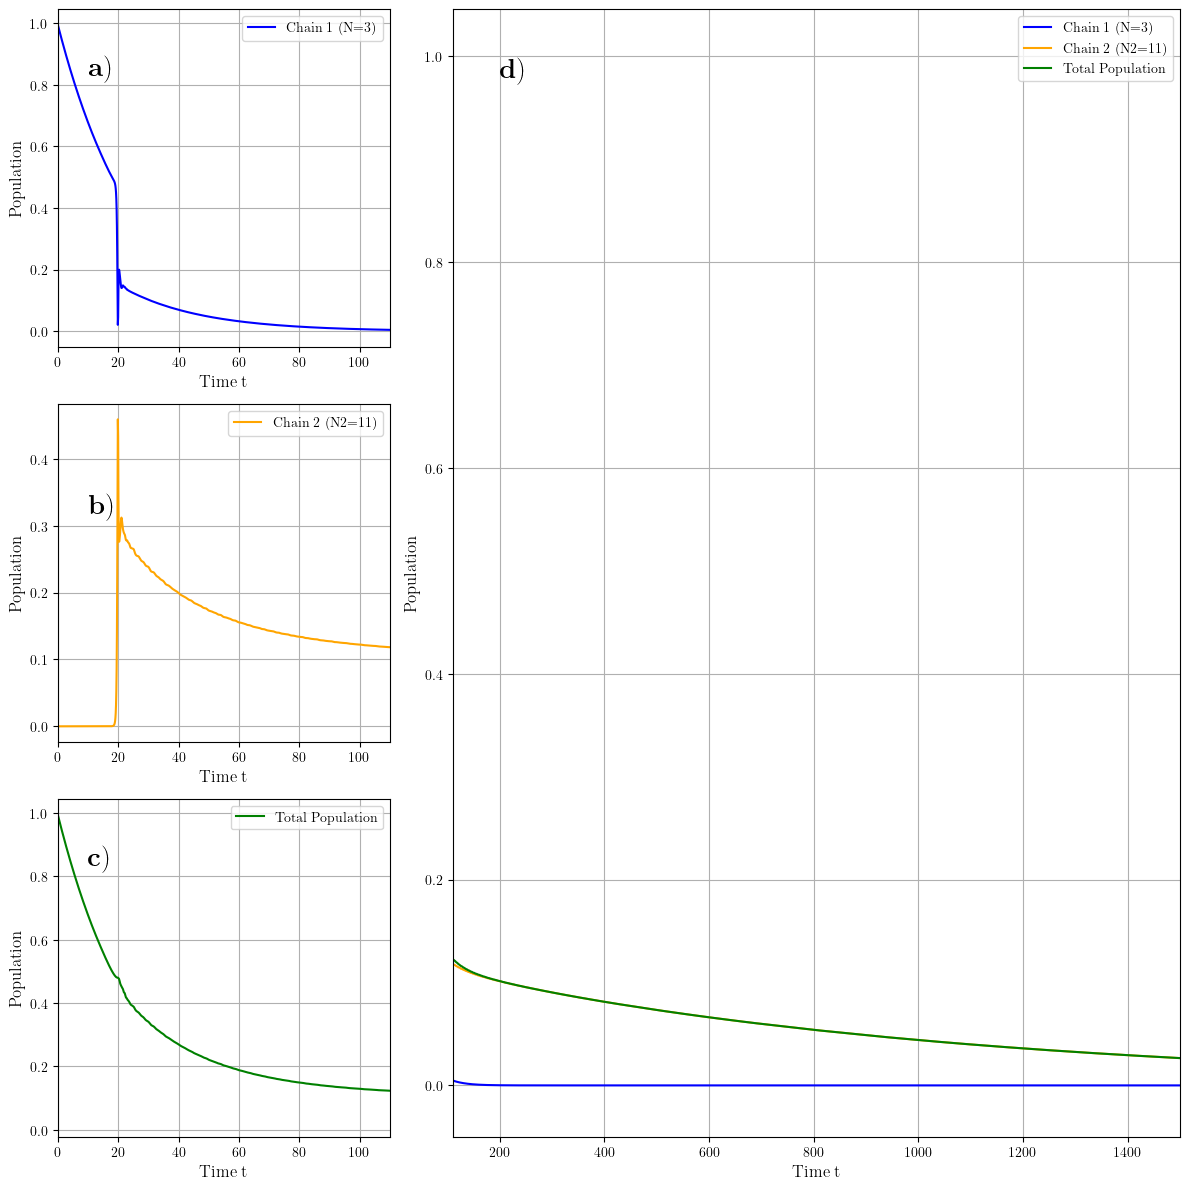

In [28]:
color_chain1 = 'blue'
color_chain2 = 'orange'
color_total = 'green'


fig = plt.figure(figsize=(12, 12))

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
ax1.plot(time, population_chain1, color=color_chain1,label='Chain 1 (N=3)')
ax1.set_xlim(0, 110)
ax1.text(10, 0.9, r'$\mathbf{a)}$', fontsize=20, fontweight='bold', verticalalignment='top')
ax1.grid(True)

ax2 = plt.subplot2grid((3, 3), (1, 0), colspan=1)
ax2.plot(time, population_chain2, color=color_chain2, label='Chain 2 (N2=11)')
ax2.text(10, 0.35, r'$\mathbf{b)}$', fontsize=20, fontweight='bold', verticalalignment='top')
ax2.set_xlim(0, 110)
ax2.grid(True)

ax3 = plt.subplot2grid((3, 3), (2, 0), colspan=1)
ax3.plot(time, population_total, color=color_total, label='Total Population')
ax3.text(10, 0.9, r'$\mathbf{c)}$', fontsize=20, fontweight='bold', verticalalignment='top')
ax3.set_xlim(0, 110)
ax3.grid(True)

ax4 = plt.subplot2grid((3, 3), (0, 1), rowspan=3, colspan=2)
ax4.plot(time, population_chain1, label='Chain 1 (N=3)', color=color_chain1)
ax4.plot(time, population_chain2, label='Chain 2 (N2=11)', color=color_chain2)
ax4.plot(time, population_total, label='Total Population', color=color_total)
ax4.set_xlim(110, T)
ax4.text(200, 1, r'$\mathbf{d)}$', fontsize=20, fontweight='bold', verticalalignment='top')
ax4.grid(True)

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel(r'Time t',fontsize=12)
    ax.set_ylabel(r'Population', fontsize=12)
    ax.legend()

plt.tight_layout()
plt.show()

In [29]:


N=33
gamma0 = 1
lambda0= 2*np.pi 
distance=lambda0/8 
k0=1 
d_value=1 

atoms = np.zeros((N, 3))

length_chain = 10 * distance

for i in range(N):
    if i < 11:
        atoms[i, 2] = i * distance * k0
    elif i < 22:
        atoms[i, 2] = 4 * np.pi + (i - 11) * distance * k0 + length_chain
    else:
        atoms[i, 2] = 8 * np.pi + (i - 22) * distance * k0 + 2 * length_chain

r = [atoms[i] for i in range(N)]
r_T = [i.reshape(-1, 1) for i in r]



d=np.array([0,d_value,0])
d_abs=np.linalg.norm(d)
d = d.reshape(-1, 1)
d_T=d.reshape(1, -1)



for i in range(N):
    for j in range(N):
        rij =r[i] - r[j]
        rij_T = rij.reshape(-1, 1)



def G0(rij,k0): 
    r0=np.linalg.norm(rij)
    rij_T = rij.reshape(-1, 1)
    return ((3*np.pi*k0*np.exp(1j*k0*r0))/(4*np.pi*(k0*r0)**3))*((k0**2*r0**2+1j*k0*r0-1)*np.identity(3)+((-k0**2*r0**2-3j*k0*r0+3)*(np.dot(rij,rij_T)/r0**2)))


def H_eff(r,d,N):
    Matrix = np.zeros((N,N), dtype=complex)
    k0=1
    for i in range(N):
        for j in range(N):
            if i == j:
                Matrix[i, j] += -1j*gamma0/2
            else:
                rij = r[i] - r[j]
                rij_T = rij.reshape(-1, 1)
                r0=np.linalg.norm(rij)
                Matrix[i, j] += -np.dot(d_T, np.dot(G0(rij,k0), d))
    return  Matrix


Hamiltonain = H_eff(r,d,N)

T=500
dt=0.1

psi_0 = np.zeros(N, dtype=complex)
psi_0[11:22] = psi_11_subradiant
psi_0 = psi_0 / np.linalg.norm(psi_0)

population_chain1 = []
population_chain2 = []
population_chain3 = []
population_total = []

overlap_chain1 = []
overlap_chain2 = []
overlap_chain3 = []

initial_distance = 4 * np.pi
target_distance = np.pi / 5
speed = (initial_distance - target_distance) / 50

time = np.arange(0, T, dt)

for t in time:
    if 0 <= t <= 50:
        for i in range(11, 22):
            atoms[i, 2] += speed * dt
    elif 50 < t <= 100:
        for i in range(11, 22):
            atoms[i, 2] -= speed * dt

    Hamiltonian = H_eff(atoms,  d, N, )
    psi_t = expm(-1j * Hamiltonian * dt) @ psi_0
    psi_0 = psi_t  

    chain1=np.sum(np.abs((psi_t[:11])**2))
    chain2=np.sum(np.abs((psi_t[11:22])**2))
    chain3=np.sum(np.abs((psi_t[22:])**2))

    """overlap with initial state"""
    overlap_chain1.append(np.abs(np.vdot(psi_11_subradiant,psi_t[:11]))**2)
    overlap_chain2.append(np.abs(np.vdot(psi_11_subradiant,psi_t[11:22]))**2)
    overlap_chain3.append(np.abs(np.vdot(psi_11_subradiant,psi_t[22:]))**2)

    population_chain1.append(chain1)
    population_chain2.append(chain2)
    population_chain3.append(chain3)
    population_total.append(np.sum(np.abs(psi_t)**2))


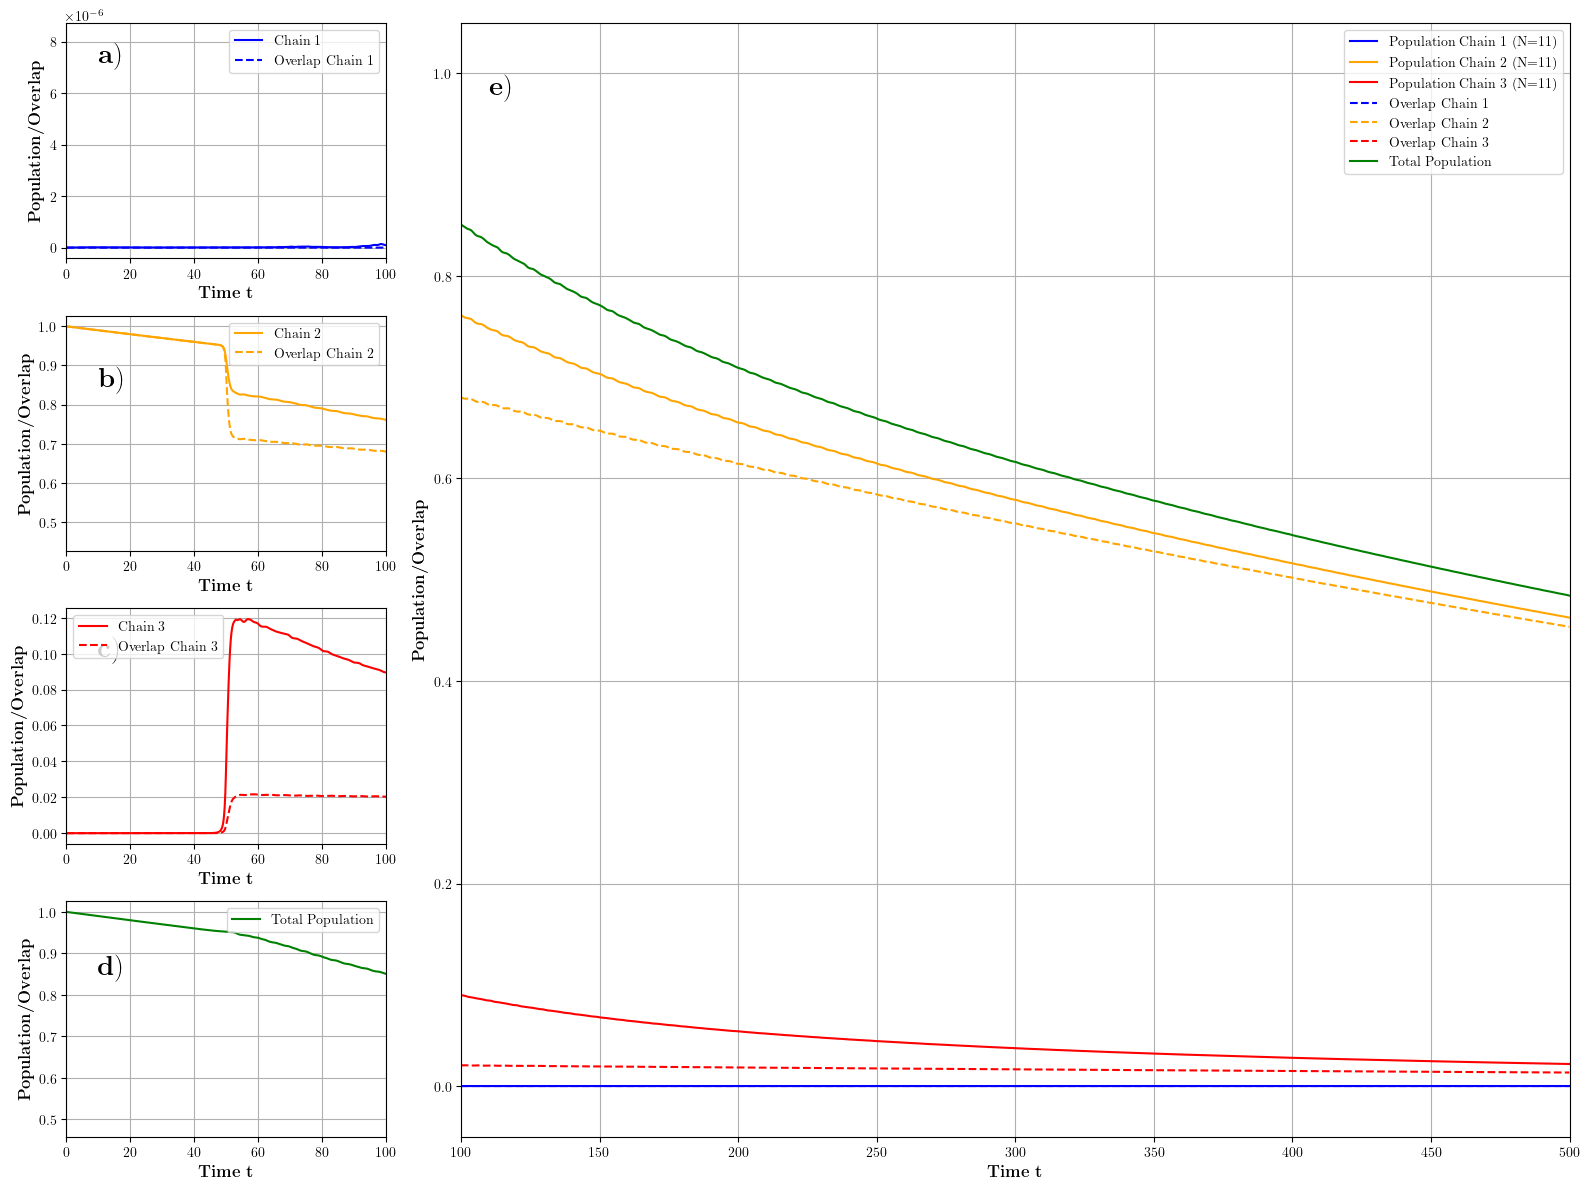

In [30]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'


fig = plt.figure(figsize=(16, 12))

color_chain1 = 'blue'
color_chain2 = 'orange'
color_chain3 = 'red'
color_total = 'green'


ax1 = plt.subplot2grid((4, 4), (0, 0), colspan=1)
ax1.plot(time, population_chain1, color=color_chain1, label='Chain 1')
ax1.plot(time, overlap_chain1, color=color_chain1, label='Overlap Chain 1', linestyle='--')
ax1.set_xlim(0, 100)
ax1.text(10, 8e-6, r'$\mathbf{a)}$', fontsize=20, fontweight='bold', verticalalignment='top')
ax1.grid(True)

ax2 = plt.subplot2grid((4, 4), (1, 0), colspan=1)
ax2.plot(time, population_chain2, color=color_chain2, label='Chain 2')
ax2.plot(time, overlap_chain2, color=color_chain2, label='Overlap Chain 2', linestyle='--')
ax2.text(10, 0.9, r'$\mathbf{b)}$', fontsize=20, fontweight='bold', verticalalignment='top')
ax2.set_xlim(0, 100)
ax2.grid(True)

ax3 = plt.subplot2grid((4, 4), (2, 0), colspan=1)
ax3.plot(time, population_chain3, color=color_chain3, label='Chain 3')
ax3.plot(time, overlap_chain3, color=color_chain3, label='Overlap Chain 3',linestyle='--')
ax3.text(10, 0.11, r'$\mathbf{c)}$', fontsize=20, fontweight='bold', verticalalignment='top')
ax3.set_xlim(0, 100)
ax3.grid(True)

ax4 = plt.subplot2grid((4, 4), (3, 0), colspan=1)
ax4.plot(time, population_total, color=color_total, label='Total Population')
ax4.text(10, 0.9, r'$\mathbf{d)}$', fontsize=20, fontweight='bold', verticalalignment='top')
ax4.set_xlim(0, 100)
ax4.grid(True)

ax5 = plt.subplot2grid((4, 4), (0, 1), rowspan=4, colspan=3)
ax5.plot(time, population_chain1, label='Population Chain 1 (N=11)', color=color_chain1)
ax5.plot(time, population_chain2, label='Population Chain 2 (N=11)', color=color_chain2)
ax5.plot(time, population_chain3, label='Population Chain 3 (N=11)', color=color_chain3)
ax5.plot(time, overlap_chain1, color=color_chain1, label='Overlap Chain 1', linestyle='--')
ax5.plot(time, overlap_chain2, color=color_chain2, label='Overlap Chain 2', linestyle='--')
ax5.plot(time, overlap_chain3, color=color_chain3, label='Overlap Chain 3',linestyle='--')
ax5.plot(time, population_total, label='Total Population', color=color_total)
ax5.set_xlim(100, 500)
ax5.text(110, 1, r'$\mathbf{e)}$', fontsize=20, fontweight='bold', verticalalignment='top')
ax5.grid(True)


for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.set_xlabel(r'\textbf{Time t}',fontsize=12)
    ax.set_ylabel(r'\textbf{Population/Overlap}',fontsize=12)
    ax.legend()

plt.tight_layout()
plt.show()